### 集成学习的思路

In [3]:
# 一个问题（如分类问题），让多种算法参与预测（如下图中的算法都可以解决分类问题），
# 在多个预测结果中，选择出现最多的预测类别做为该样本的最终预测类别；

In [4]:
# 比如我用knn、逻辑回归、决策树、SVM算法分别预测结果，按结果少数服从多数选出最终的类别

#### 模拟集成学习

In [ ]:
# sklearn中集成了一种叫VotingClassifier的

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

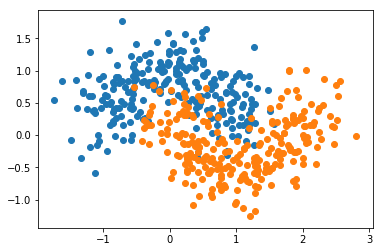

In [20]:
# 生成数据
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)

X.shape

plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [22]:
# 先使用逻辑回归，预测一把
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
log_reg.score(X_test,y_test)

0.864

In [23]:
# 然后使用svm，预测一把
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.888

In [24]:
# 然后使用决策树，预测一把
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
dt_clf.score(X_test, y_test)

0.848

In [26]:
# 对上述上个算法进行投票
y_predict1 = log_reg.predict(X_test)
y_predict2 = svc.predict(X_test)
y_predict3 = dt_clf.predict(X_test)

In [29]:
# 怎么投票?  少数服从多数
y_predict = np.array(y_predict1 + y_predict2 + y_predict3 >= 2, dtype='int')
y_predict

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

In [30]:
# 此时我们再看准确率
from sklearn.metrics import accuracy_score

accuracy_score(y_predict, y_test)

0.896

In [32]:
# 我们看此时，经过集成之后，准确率是最高的

#接下来看看sklearn中封装的集成学习

#### 使用sklearn中的集成学习

In [33]:
from sklearn.ensemble import VotingClassifier

In [34]:
# 集成分类器 VotingClassifier 的参数：
    # 1）estimators=[]：传入需要使用的算法，放在列表中，使用方式类似管道 Pipeline；
    # 2）voting='hard'：表示选择最终预测结果的方式，以出现最多的分类结果作为最终的预测结果；
# 正常情况下，需要对所选择的算法进行调参；

In [38]:
voting_clt = VotingClassifier(estimators=[
    ('log_reg', LogisticRegression()),
    ('svm_clf', SVC()),
    ('dt_clf', DecisionTreeClassifier())
], voting='hard')

In [39]:
voting_clt.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('svm_clf...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [40]:
voting_clt.score(X_test,y_test)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.904

In [41]:
# 正常情况下，需要对所选择的算法进行调参；
# 当然我们对每个分类器分布进行调参后，在放到estimators中

#### soft Voting

In [43]:
# 跟前面的hard模式相对，soft投票模式就是每个分类器的投票是有权重的，hard模式就是所有人的权重都是相等的，少数服从多数决定判定结果
# hard模式有个问题就是有些分类器可能是专家（结果更应该相信他）

In [44]:
# 将所有模型预测样本为某一类别的概率的平均值作为标准，概率最高的对应的类型为最终的预测结果；

<img src="./图片/soft_voting.png">

In [45]:
# Soft Voting 的决策方式，要求集合的每一个模型都能估计概率；

In [46]:
# 1、逻辑回归 支持返回概率，对吧
# 2、KNN 也支持，n：k 个样本中，最终确定的类型的个数；比如，最终判断为 红色类型，概率：p = n/k = 2 / 3；
# 3、决策树 通常在“叶子”节点处的信息熵或者基尼系数不为 0，数据集中包含多种类别的数据，
# 以数量最多的样本对应的类别作为最终的预测结果；（和 kNN 算法类似）

# 4、SVM算法中，本来是不支持的，不过我们可以设置参数让他支持概率 svc = SVC(probability=True)

In [47]:
voting_clt2 = VotingClassifier(estimators=[
    ('log_reg', LogisticRegression()),
    ('svm_clf', SVC(probability=True)),
    ('dt_clf', DecisionTreeClassifier())
], voting='soft')

In [48]:
voting_clt2.fit(X_train,y_train)

VotingClassifier(estimators=[('log_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('svm_clf...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [49]:
voting_clt2.score(X_test,y_test)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.92

In [50]:
# 比hard模式的结果要好

In [51]:
# 集成多个算法，让不同的算法对同一组数据进行分析，得到结果，最终投票决定各个算法公认的最好的结果；
# 弊端：虽然有很多机器学习的算法，但是从投票的角度看，仍然不够多；如果想要有效果更好的投票结果，
# 最好有更多的算法参与；（概率论中称大数定理）也就是投票者越多，效果越好

In [52]:
# 另一个想法是，让每个子模型（模拟器）之间有更大的差异，广泛听取各方意见

In [53]:
# 怎么创建这么多的有差异的子模型呢？？

In [54]:
# 有个思路就是每个子模型只使用样本数据的一部分；
#（也就是说，如果一共有 500 个样本数据，每个子模型只看 100 个样本数据，每个子模型都使用同一个算法）

# 由于将样本数据平分成 5 份，每份 100 个样本数据，每份样本数据之间有差异，因此所训练出的 5 个子模型之间也存在差异；
# 5 个子模型的准确率低于使用全部样本数据所训练出的模型的准确率；
# 实际应用中，每个子模型的准确率有高有低，甚至有些子模型的准确率低于 50%；


# 集成的众多模型中，并不要求子模型有更高的准确率，
# 只要子模型的准确率大于 50%，在集成的模型当中，随着子模型数量的增加，集成学习的整体的准确率升高；

<img src='./图片/子模型.png'>

In [57]:
# 关于怎么分解样本

# 放回取样（Bagging）
#     统计学中，放回取样称为 bootstrap； 用的比较多

# 不放回取样（Pasting）

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=200, bootstrap=True)

# DecisionTreeClassifier()：表示需要根据什么算法生产子模型；
# n_estimators=500：集成 500 个子模型；
# max_samples=200：每个子模型看 200 个样本数据；
# bootstrap=True：表示采用 Bagging 的方式从样本数据中取样；（默认方式）
# bootstrap=False：表示采用 Pasting 的方式从样本数据中取样；
 

In [59]:
bagging_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=200, n_estimators=500, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [60]:
bagging_clf.score(X_test,y_test)

0.904

In [61]:
'''
机器学习的过程没有一定之规，没有soft永远比hard好的结论（如果是那样，我们实现的接口就根本不需要hard这个选项了；
并不是说子模型数量永远越多越好，一切都要根据数据而定，对于一组具体的数据，如论是soft还是hard，亦或是子模型数量，都是超参数，在实际情况都需要根据数据进行一定的调节。
在机器学习的世界里，在训练阶段，并不是准确率越高越好。因为准确率高有可能是过拟合。应该是“越真实越好”。
所谓的真实是指结果要能“真实”的反应训练数据和结果输出的关系。
在真实的数据中，使用验证数据集是很重要的：）
'''

'\n机器学习的过程没有一定之规，没有soft永远比hard好的结论（如果是那样，我们实现的接口就根本不需要hard这个选项了；\n并不是说子模型数量永远越多越好，一切都要根据数据而定，对于一组具体的数据，如论是soft还是hard，亦或是子模型数量，都是超参数，在实际情况都需要根据数据进行一定的调节。\n在机器学习的世界里，在训练阶段，并不是准确率越高越好。因为准确率高有可能是过拟合。应该是“越真实越好”。\n所谓的真实是指结果要能“真实”的反应训练数据和结果输出的关系。\n在真实的数据中，使用验证数据集是很重要的：）\n'

#### bagging模式更多的讨论

In [63]:
# 返回抽样有个问题，就是由于随机的原因，在N次重复抽样下，大概有37%的数据可能没有被取样到，这些数据集叫做 oob （out of bagging）
# 所以我们完全可以用这个oob数据进行验证集，对吧，因为从来没有被取样到

In [64]:
# 如果在sklearn中设置oob_score = True：表示使用 oob 数据集作为验证数据集；

In [81]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


bagging_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, oob_score=True)

bagging_clf.fit(X,y)

Wall time: 709 ms


In [76]:
# 我们可以使用oob_score_ 变量，查看模型在 oob 数据集上的准确率
bagging_clf.oob_score_

0.916

In [70]:
# oob的并行化计算

# 实际上对于这种放回抽样模式，非常容易实现并行化处理。
# 对于每一个子模型都是独立的随机抽取训练数据集，而且每个子模型的训练也都是独立的，所有系统可以对所有的子模型并行处理；
# 在机器学习中，对于所有可以并行处理的算法，都需要对参数 n_jobs 进行确认：
# n_jobs = n：程序就会使用服务器的 n 个核，同时进行处理；
# n_jobs = -1：使用电脑所有的核；

In [85]:
%%time
bagging_clf2 = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=100, 
                               bootstrap=True, oob_score=True,
                               n_jobs=-1)
bagging_clf2.fit(X, y)

Wall time: 3.44 s


#### 子模型差异化的方式

In [71]:
# 之前说过对样本进行随机取部分样本也就是bagging方式，可以让子模型差异化
# 不过还有另一种差异化的方式，那就是在样本的特征维度上也随机取部分样本。

In [72]:
# 也就是 n 维的数据集，每次只取 k 维作为样本的特征，形成一个新的数据集；新的数据集的特征空间是原始数据集的特征空间的子空间；（k < n）

In [86]:
# bootstrap_features 方式：即针对样本数量，又针对特征进行取样；
# bootstrap_features=True：表示采用放回取样的方式对特征进行取样；

In [87]:
random_subspaces_clf = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500, max_samples=100, 
                               bootstrap=True, oob_score=True,
                               n_jobs=-1, max_features=1, bootstrap_features=True)
random_subspaces_clf.fit(X, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=True, max_features=1,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [88]:
random_subspaces_clf.oob_score_

0.86

In [89]:
# 上面这种使用决策树算法集成学习得到的子模型，称为随机森林

### 随机森林

In [1]:
# sklearn中的随机森林
# 特点：
#     是在所有子模型在节点划分时，都是在随机的特征子集上寻找最优的花饭特征；
#     也就是在迭代寻找划分维度及其阈值时，不是对全部特征进行搜索，而是对部分特征进行搜索；


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

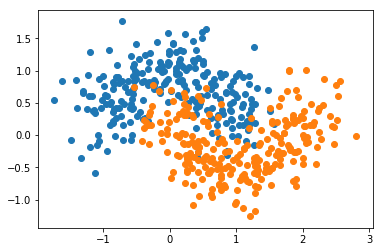

In [4]:
X,y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)

plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()


In [7]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, random_state=666, oob_score=True, n_jobs=-1)

rf_clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=666, verbose=0, warm_start=False)

In [8]:
rf_clf.oob_score_

0.896

In [10]:
rf_clf2 = RandomForestClassifier(n_estimators=500, random_state=666, oob_score=True, n_jobs=-1,max_depth=2)

rf_clf2.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=666, verbose=0, warm_start=False)

In [11]:
rf_clf2.oob_score_

0.86

In [12]:
# 属于决策树算法和集成学习算法共同的参数

#     max_depth = None：决策树的最高深度；（如果不做设置，按其它参数条件结束划分）
#     max_features = 'auto'：节点划分时，进行所搜的特征的种类数；（默认搜索全部特征）
#     max_leaf_nodes = None：划分结束时，模型最多的叶子数；（如果不做设置，按其它参数条件结束划分）
#     min_impurity_decrease = 0.0：


#### Extra-Tree

In [2]:
# Extra-Tree


#     特点：决策树子模型在节点划分时，使用随机的特征和随机的阈值；

#     也就是说，节点划分时，选择的特征及对应的特征值不是搜索比较所得，而是随机抽取一个特征，
#      再从该特征中随机抽取一个特征值，作为该节点划分的依据；

""" 也就是完全随机"""

#     理论支撑：只要子模型的准确率大于 50%，并且集成的子模型的数量足够多，最终整个集成系统的准确率就能达到要求；

#     优点：提供额外的随机性，抑制过拟合；并且具有更快的训练速度，因为完全随机，不用计算熵或者gini系数；
#     缺点：增大了 bias（偏差）；


' 也就是完全随机'

In [8]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(n_estimators=500, bootstrap=True, oob_score=True, random_state=666)
et_clf.fit(X,y)

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=True, random_state=666, verbose=0, warm_start=False)

In [9]:
et_clf.oob_score_

0.892

In [10]:
# 集成学习解决回归问题
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [11]:
# boston 房价例子测试。

### Boosting

In [13]:
# 和Bagging不同，每个模型都在尝试增强整体的效果


#     Boosting 类的集成学习，主要有：Ada Boosting 和 Gradient Boosting 两类；

#     由于每个子模型要使用全部的数据集进行训练，因此 Ada Boosting 算法中没有 oob 数据集，在使用 Ada Boosting 算法前，
#     需要划分数据集：train_test_split；

#     每个 Ada Boosting 集成学习算法的模型只使用一个基本算法进行训练子模型；

#     相对于集成学习方法，决策树算法、SVM 算法、逻辑回归算法等，称为基本的学习方法；


#### Ada Boosting

<img src="./图片/ada_boosting.png">

In [14]:

#     假设是一个回归问题：图的最下层代表全部的训练数据集，深色的点为模型预测错误的点，定义为权重高样本，
#     需要下一次生成的子模型时被重点对待；浅色的点为模型预测成功的点，定义为权重低样本；
#     图的中间层代表一种基本算法；
#     图的最上层代表算法根据拥有不同权重的样本的数据集，所训练出的模型；
#     箭头表示不同的子模型按一定规律生成；

#     解释上图过程（Ada Boosting 的思路）：第一次进行学习得到第一个子模型，根据第一子模型的预测结果重新定义数据集
#         ——将预测错误的点（深色点）划分较高权重，将预测成功的点（浅色点）划分较低权重；第二次进行学习时，
#         使用上一次学习后被重新定义的数据集进行训练，再根据模型的预测结果重新定义数据集——将预测错误的点（深色点）划分较高权重，
#         将预测成功的点（浅色点）划分较低权重；以此类推，最终得到 n 个子模型；

 

In [15]:

#     每一次生成的子模型都在想办法弥补上一次生成的子模型没有成功预测到的样本点，或者说是弥补上一子模型所犯的错误；
#     也可以说，每一个子模型都在想办法推动（Boosting）整个基础系统，使得整个集成系统准确率更高；
#     每一个子模型都是基于同一数据集的样本点，只是样本点的权重不同，也就是样本对于每一个子模型的重要程度不同，
#     因此每份子模型也是有差异的；最终以所有子模型综合投票的结果作为 Ada Boosting 模型的最终学习结果；


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [18]:
X, y = datasets.make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=500) #500个决策树子模型
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=500, random_state=None)

In [20]:
ada_clf.score(X_test,y_test)

0.84

#### Gradient Boosting

In [ ]:

#     使用整体的数据集训练第一个子模型 m1，产生错误 e1（m1 模型预测错误的样本数据）；
#     使用 e1 数据集训练第二个子模型 m2，产生错误 e2；
#     使用 e2 数据集训练第三个子模型 m3，产生错误 e3；
#     。。。
#     最终的预测结果是：m1 + m2 + m3  +  。。。（回归问题）


<img src="./图片/grad_boosting.png">

In [22]:

#     上图左侧绿色的线，子模型，从上到下： m1、m2、m3 模型；
#     上图右侧的红线，集成算法模型，随着子模型的增多，集成算法模型的整体变化情况，从上到下：m1、m1 + m2、m1 + m2 + m3


In [23]:

#     每一个模型都是对前一个模型所犯错误的补偿；
#     Gradient Boosting 集成学习算法不能对基本算法进行选择，它的的基本算法就是决策树算法；


In [24]:
from sklearn.ensemble import GradientBoostingClassifier

# 由于 Gradient Boosting 集成学习算法的基本算法只能用决策树算法，因此在设定参数时，不需要传入基本算法，而直接传决策树算法需要的参数；

gd_clf = GradientBoostingClassifier(max_depth=2, n_estimators=30)
gd_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=30,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [25]:
gd_clf.score(X_test,y_test)

0.912

#### stacking集成学习思路

In [ ]:
# 下图为堆叠集成算法的模型，新的样本讲过 3 种模型的预测，得到 3 个预测结果，(如果是前面说的voting的化，会直接对这三个结果进行投票，决定
#           哪一类)
# 而stacking的做法是，再将 3 个预测结果作为输入传递该上层的一个模型得到一个预测值，
# 则认为该预测概率值为最终的预测结果。

In [ ]:
# stacking 比voting多了一层模型（blending层）

<img src="./图片/stacking.png">

#### 怎么训练stacking

<img src="./图片/训练stacking.png">

In [27]:
# 1、将整个训练样本分成2份，一部分用来训练底下的三个子模型，而另一部分用于blending层训练模型得到输出概率值。
# 将Subset 2 分别扔进三个已经训练好的样本，得到预测值，在和Subset2中的对应的真值组成新的训练集，仍经Blending层训练
#     得到预测结果。

#### 更加复杂的stacking

<img src="./图片/多层stacking.png">

In [30]:
# 这个模型的特点就是通过使用第一阶段（layer 1）的预测作为下一层预测的特征，比起相互独立的预测模型能够有更强的非线性表述能力，
# 降低泛化误差。它的目标是同时降低机器学习模型的Bias-Variance

In [28]:

#     思路：如上图所示；

#     将训练数据集分割为 3 份（有几层就将 X_train 分成几份）：X_train_1、X_train_2、X_train_3，使用  
#             X_train_1 训练出 3 个模型（训练方式可以有多种）；（得到第一层的 3 个模型）

#     将 X_train _2 数据集传入 3 个模型，得到 3 组预测结果，将 3 组预测结果与 X_train_2 数据集中的  y  值
#             一起组合成一个新的数据集 X_train_new_1；（得到第一个新的数据集：X_train_new_1）

#     使用 X_train_new_1 数据集再训练出 3 个模型，为第二层的模型；（得到第二层的 3 个模型）

#     将 X_train _3 数据集传入第二层的 3 个模型，得到 3 组预测结果，再将 3 组预测结果与 X_train_3 数据集中
#             的  y  值一起组合成一个新的数据集 X_train_new_2；（得到第二个新的数据集：X_train_new_2）

#     使用 X_train_new_2 训练出一个模型，作为最高层的模型；（得到第三层的 1 个模型）

#     系统超参数：层数、每层的模型个数；

In [ ]:

#     上图的逻辑思想类似神经网络，只不过对应神经网络来说，每一个神经元不是一个全新的算法，
#             而只是计算一个函数的值；相应的，对应神经网络来说，如果层数增多的话就达到了深度学习的模型；

#     神经网络因其灵活度较高，容易出现过拟合；很多深度学习的话题，其本质就是在探讨，
#             对于这样一个复杂的模型，如何解决其过拟合的问题；其中很多的方法也使用于 Stacking 集成学习算法；

#     scikit-learn 中没有封装 Stacking 集成算法；
